In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
!ls /content/drive/Shareddrives/DA231o-2024-shared/assignments/SparkData/spark-3.5.2-bin-hadoop3.tgz
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!tar xf /content/drive/Shareddrives/DA231o-2024-shared/assignments/SparkData/spark-3.5.2-bin-hadoop3.tgz
!pip install -q findspark
!pip install -q pyspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.2-bin-hadoop3"

/content/drive/Shareddrives/DA231o-2024-shared/assignments/SparkData/spark-3.5.2-bin-hadoop3.tgz


In [17]:
# !ls /content/data

# !mkdir -p /content/data
# !rm -rf /content/data/*.csv
# !ln -s /content/drive/MyDrive/Data-scale-project/dataset/*.csv /content/data/
# !ls /content/data

In [18]:
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
input_type = 'sample'
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()

In [19]:
# def read_csv(path_to_file):
#   return spark.read.csv(path_to_file, header=True, inferSchema=True)

# cdc_df = read_csv('/content/data/diabetes_binary_health_indicators_BRFSS2015.csv')
# pima_df = read_csv('/content/data/diabetes.csv')

In [20]:
# reading data sets
import os


cdc_url = 'https://raw.githubusercontent.com/kapsoniiisc/diabetes-dsp-project/refs/heads/main/Dataset/diabetes_binary_health_indicators_BRFSS2015.csv'
pima_url = 'https://raw.githubusercontent.com/kapsoniiisc/diabetes-dsp-project/refs/heads/main/Dataset/diabetes.csv'


os.system(f"wget {cdc_url} -O /content/diabetes_binary_health_indicators_BRFSS2015.csv")
os.system(f"wget {pima_url} -O /content/diabetes.csv")

# Step 5: Read the CSV files into Spark DataFrames
cdc_df = spark.read.csv('/content/diabetes_binary_health_indicators_BRFSS2015.csv', header=True, inferSchema=True)
pima_df = spark.read.csv('/content/diabetes.csv', header=True, inferSchema=True)


In [21]:
cdc_df.printSchema()
pima_df.printSchema()
print(cdc_df.columns)
print(pima_df.columns)

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from random import sample
from pyspark.sql.types import DoubleType


root
 |-- Diabetes_binary: double (nullable = true)
 |-- HighBP: double (nullable = true)
 |-- HighChol: double (nullable = true)
 |-- CholCheck: double (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Smoker: double (nullable = true)
 |-- Stroke: double (nullable = true)
 |-- HeartDiseaseorAttack: double (nullable = true)
 |-- PhysActivity: double (nullable = true)
 |-- Fruits: double (nullable = true)
 |-- Veggies: double (nullable = true)
 |-- HvyAlcoholConsump: double (nullable = true)
 |-- AnyHealthcare: double (nullable = true)
 |-- NoDocbcCost: double (nullable = true)
 |-- GenHlth: double (nullable = true)
 |-- MentHlth: double (nullable = true)
 |-- PhysHlth: double (nullable = true)
 |-- DiffWalk: double (nullable = true)
 |-- Sex: double (nullable = true)
 |-- Age: double (nullable = true)
 |-- Education: double (nullable = true)
 |-- Income: double (nullable = true)

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- Blood

In [22]:
feature_columns = ['BMI', 'Age', 'HighBP', 'Smoker', 'PhysActivity', 'GenHlth', 'PhysHlth']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_cdc_df = assembler.transform(cdc_df).select("features", "Diabetes_binary")

# Step 7: Scale Features to improve on imbalance data
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaled_df = scaler.fit(assembled_cdc_df).transform(assembled_cdc_df)

# Step 8: Train-Test Split
train_df_cdc, test_df_cdc = scaled_df.randomSplit([0.8, 0.2], seed=42)

# Step 9: Train Logistic Regression Model
lr = LogisticRegression(featuresCol="scaled_features", labelCol="Diabetes_binary", maxIter=10)
lr_model = lr.fit(train_df_cdc)

# Evaluate Logistic Regression Model
evaluator = BinaryClassificationEvaluator(labelCol="Diabetes_binary", metricName="areaUnderROC")
lr_predictions = lr_model.transform(test_df_cdc)
lr_roc_auc = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression ROC AUC For CDC Data: {lr_roc_auc}")


Logistic Regression ROC AUC For CDC Data: 0.8075300444250557


Accuracy: 0.8595695377243627
Precision: 0.8208973645023433
Recall: 0.8595695377243628
F1 Score: 0.8192726327505367


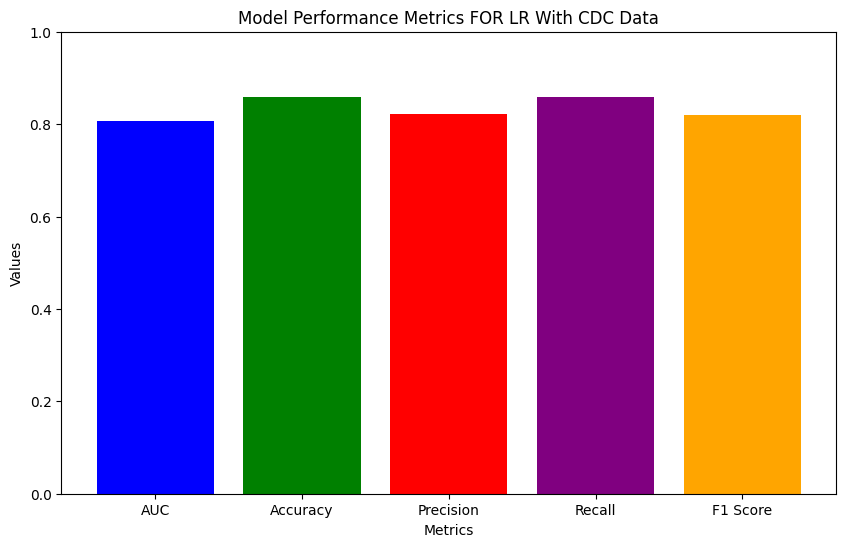

In [23]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Step 1: Make Predictions
predictions = lr_model.transform(test_df_cdc)  # Replace with the model of your choice

# Step 2: Define the evaluator for precision, recall, and F1 score
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="Diabetes_binary", predictionCol="prediction")


accuracy = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "accuracy"})
print(f"Accuracy: {accuracy}")

# Calculate precision
precision = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "weightedPrecision"})
print(f"Precision: {precision}")

# Calculate recall
recall = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "weightedRecall"})
print(f"Recall: {recall}")

# Calculate F1-score
f1_score = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "f1"})
print(f"F1 Score: {f1_score}")

import matplotlib.pyplot as plt

# Metrics to plot
metrics = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [lr_roc_auc, accuracy, precision, recall, f1_score]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Model Performance Metrics FOR LR With CDC Data')
plt.ylim(0, 1)
plt.show()

In [24]:
class_counts = pima_df.groupBy("Outcome").count().collect()
total_count = sum(row["count"] for row in class_counts)
class_weights = {row["Outcome"]: total_count / row["count"] for row in class_counts}
total_weight = sum(class_weights.values())
class_weights = {key: val / total_weight for key, val in class_weights.items()}

# Add weight column to handle the imbalance data
combined_pima_df = pima_df.withColumn(
    "weight",
    when(col("Outcome") == 1, lit(class_weights[1])).otherwise(lit(class_weights[0]))
)

feature_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_pima_df = assembler.transform(combined_pima_df).select("features", "Outcome","weight")

# Step 7: Scale Features to improve on imbalance data
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaled_df = scaler.fit(assembled_pima_df).transform(assembled_pima_df)

# Step 8: Train-Test Split
train_df_pima, test_df_pima = scaled_df.randomSplit([0.8, 0.2], seed=42)

# Step 9: Train Logistic Regression Model
lr = LogisticRegression(featuresCol="scaled_features", labelCol="Outcome", weightCol="weight", maxIter=10)
lr_model = lr.fit(train_df_pima)

# Evaluate Logistic Regression Model
evaluator = BinaryClassificationEvaluator(labelCol="Outcome", metricName="areaUnderROC")
lr_predictions = lr_model.transform(test_df_pima)
lr_roc_auc = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression ROC AUC For PIMA Data: {lr_roc_auc}")

Logistic Regression ROC AUC For PIMA Data: 0.8803418803418804


Accuracy: 0.7398373983739838
Precision: 0.7812964653710708
Recall: 0.7398373983739837
F1 Score: 0.748286127878076


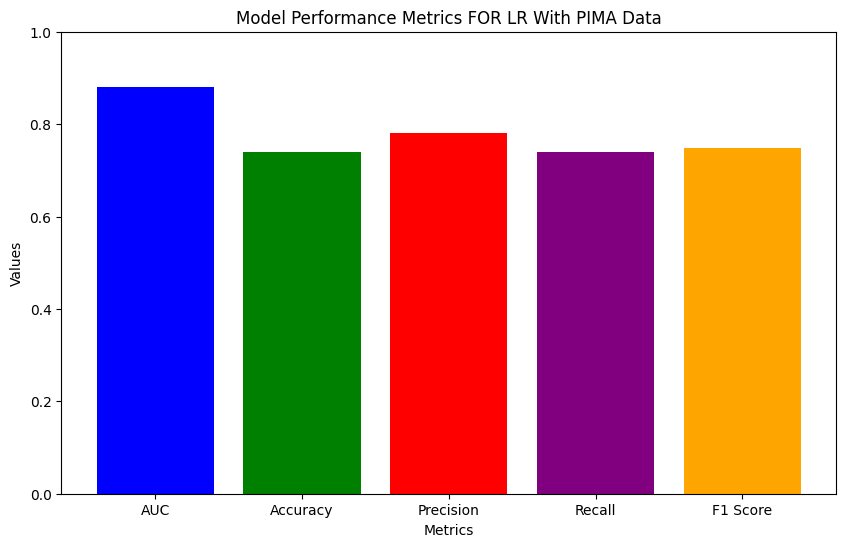

In [25]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Step 1: Make Predictions
predictions = lr_model.transform(test_df_pima)  # Replace with the model of your choice

# Step 2: Define the evaluator for precision, recall, and F1 score
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction")


accuracy = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "accuracy"})
print(f"Accuracy: {accuracy}")

# Calculate precision
precision = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "weightedPrecision"})
print(f"Precision: {precision}")

# Calculate recall
recall = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "weightedRecall"})
print(f"Recall: {recall}")

# Calculate F1-score
f1_score = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "f1"})
print(f"F1 Score: {f1_score}")
import matplotlib.pyplot as plt

# Metrics to plot
metrics = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [lr_roc_auc, accuracy, precision, recall, f1_score]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Model Performance Metrics FOR LR With PIMA Data')
plt.ylim(0, 1)
plt.show()

In [26]:
from pyspark.sql.functions import round, floor, col, when
from pyspark.sql.types import DoubleType

pima_df = pima_df.withColumn(
    'AGEG5YR',
    when((col('Age') >= 18) & (col('Age') <= 24), 1)
    .when((col('Age') >= 25) & (col('Age') <= 29), 2)
    .when((col('Age') >= 30) & (col('Age') <= 34), 3)
    .when((col('Age') >= 35) & (col('Age') <= 39), 4)
    .when((col('Age') >= 40) & (col('Age') <= 44), 5)
    .when((col('Age') >= 45) & (col('Age') <= 49), 6)
    .when((col('Age') >= 50) & (col('Age') <= 54), 7)
    .when((col('Age') >= 55) & (col('Age') <= 59), 8)
    .when((col('Age') >= 60) & (col('Age') <= 64), 9)
    .when((col('Age') >= 65) & (col('Age') <= 69), 10)
    .when((col('Age') >= 70) & (col('Age') <= 74), 11)
    .when((col('Age') >= 75) & (col('Age') <= 79), 12)
    .when((col('Age') >= 80) & (col('Age') <= 99), 13)
    .otherwise(14)
    .cast(DoubleType())  # Cast the new column to DoubleType
)



pima_df = pima_df.withColumn('HighBP', when(col('BloodPressure') > 80, 1).otherwise(0))
pima_df.drop('Age')
pima_df.show(5)

cdc_df = cdc_df.withColumnRenamed("Age", "AGEG5YR")
cdc_df.show(5)
#HIghBP , HighChol , BMI, PhysicalActivity , GenHlth , MentHlth , PhysHlth , Age , Eduation and Income.

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+-------+------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|AGEG5YR|HighBP|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+-------+------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|    7.0|     0|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|    3.0|     0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|    3.0|     0|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|    1.0|     0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|    3.0|     0|
+-----------+-------+-------------+-------------+-------+----+------------------

Logistic Regression ROC AUC For combined CDC adn PIMA: 0.8091422406247148
LR Accuracy For combined CDC adn PIMA: 0.7214032614866585
LR Precision For combined CDC adn PIMA: 0.8559129973280918
LR Recall For combined CDC adn PIMA: 0.7214032614866583
LR F1 Score For combined CDC adn PIMA: 0.7613710845946444


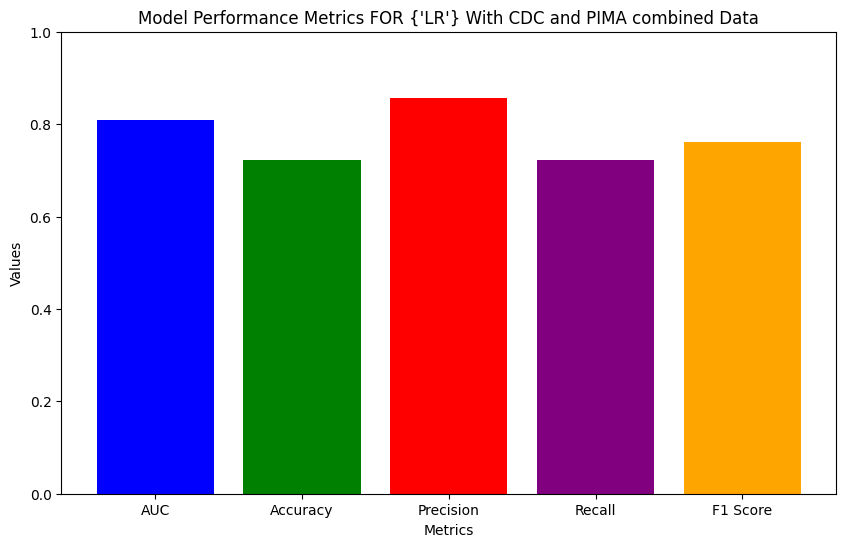

Random Forest ROC AUC: 0.7781450317587632
RF Accuracy For combined CDC adn PIMA: 0.8588124743055148
RF Precision For combined CDC adn PIMA: 0.7375588660227604
RF Recall For combined CDC adn PIMA: 0.8588124743055148
RF F1 Score For combined CDC adn PIMA: 0.7935807148037625


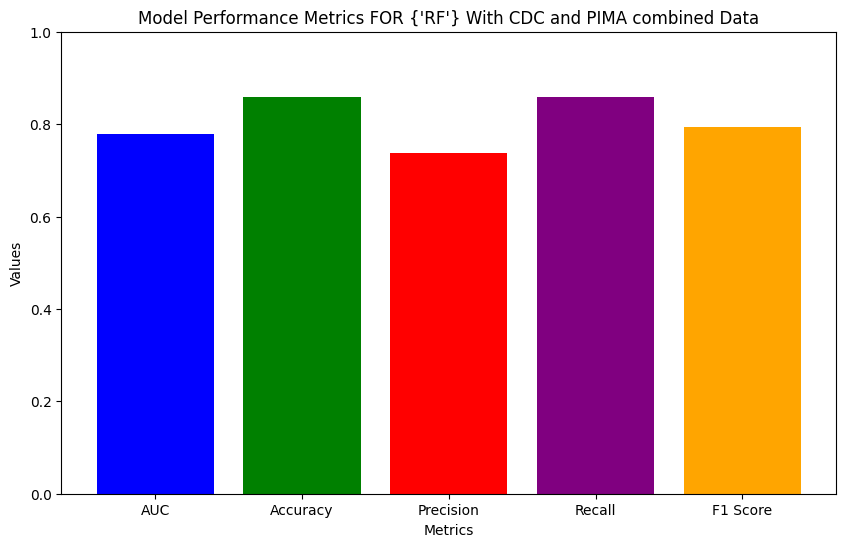

GBT ROC AUC: 0.815691930420534
GBT Accuracy For combined CDC adn PIMA: 0.8623362894226816
GBT Precision For combined CDC adn PIMA: 0.8279503832412004
GBT Recall For combined CDC adn PIMA: 0.8623362894226816
GBT F1 Score For combined CDC adn PIMA: 0.8246060813375077


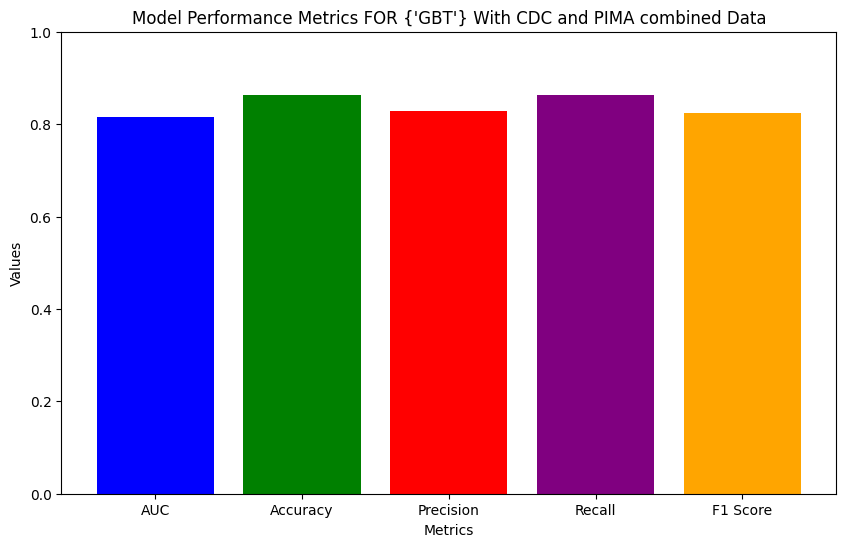

Cross-Validated Logistic Regression ROC AUC: 0.808968901790205
Cross-Validated Randomized Random Forest ROC AUC: 0.7866096128837776


In [27]:
# Import Modules
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from random import sample
from pyspark.sql.types import DoubleType

def calculate_metrics_and_plot(test_df,lr_roc_auc,lr_model,model_name='LR'):
  from pyspark.ml.evaluation import MulticlassClassificationEvaluator

  # Step 1: Make Predictions
  predictions = lr_model.transform(test_df)  # Replace with the model of your choice

  # Step 2: Define the evaluator for precision, recall, and F1 score
  multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction")


  accuracy = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "accuracy"})
  print(f"{model_name} Accuracy For combined CDC adn PIMA: {accuracy}")

  # Calculate precision
  precision = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "weightedPrecision"})
  print(f"{model_name} Precision For combined CDC adn PIMA: {precision}")

  # Calculate recall
  recall = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "weightedRecall"})
  print(f"{model_name} Recall For combined CDC adn PIMA: {recall}")

  # Calculate F1-score
  f1_score = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "f1"})
  print(f"{model_name} F1 Score For combined CDC adn PIMA: {f1_score}")


  import matplotlib.pyplot as plt

  # Metrics to plot
  metrics = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
  values = [lr_roc_auc, accuracy, precision, recall, f1_score]

  # Create the bar chart
  plt.figure(figsize=(10, 6))
  plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple', 'orange'])
  plt.xlabel('Metrics')
  plt.ylabel('Values')
  plt.title('Model Performance Metrics FOR {} With CDC and PIMA combined Data'.format({model_name}))
  plt.ylim(0, 1)
  plt.show()



#
# Step 1: Preprocessing CDC Dataset
cdc_df = cdc_df.withColumnRenamed("Diabetes_binary", "Outcome")
cdc_features = ['BMI', 'HighBP', 'Smoker', 'PhysActivity', 'GenHlth', 'PhysHlth', 'AGEG5YR', 'Outcome']
cdc_df = cdc_df.select(cdc_features)

# Step 2: Preprocessing Pima Dataset
pima_features = ['BMI', 'HighBP', 'AGEG5YR', 'Insulin','Outcome']
pima_df = pima_df.select(pima_features)

# Step 3: Align Schema by Adding Missing Columns


cdc_df = cdc_df.withColumn("Insulin", lit(0).cast(DoubleType()))

pima_df = pima_df.withColumn("GenHlth", lit(0).cast(DoubleType())) \
                 .withColumn("Smoker", lit(0).cast(DoubleType())) \
                 .withColumn("PhysActivity", lit(0).cast(DoubleType())) \
                 .withColumn("PhysHlth", lit(0).cast(DoubleType()))

# Combine datasets
combined_df = cdc_df.union(pima_df)

# Step 4: Handle Missing Values
combined_df = combined_df.fillna(0)

# Step 5: Calculate Class Weights as we have imbalance data
class_counts = combined_df.groupBy("Outcome").count().collect()
total_count = sum(row["count"] for row in class_counts)
class_weights = {row["Outcome"]: total_count / row["count"] for row in class_counts}
total_weight = sum(class_weights.values())
class_weights = {key: val / total_weight for key, val in class_weights.items()}

# Add weight column to handle the imbalance data
combined_df = combined_df.withColumn(
    "weight",
    when(col("Outcome") == 1, lit(class_weights[1])).otherwise(lit(class_weights[0]))
)

# Step 6: Feature Engineering
feature_columns = ['BMI', 'AGEG5YR', 'HighBP', 'Smoker', 'PhysActivity', 'GenHlth', 'PhysHlth']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_df = assembler.transform(combined_df).select("features", "Outcome", "weight")

# Step 7: Scale Features to improve on imbalance data
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaled_df = scaler.fit(assembled_df).transform(assembled_df)

# Step 8: Train-Test Split
train_df, test_df = scaled_df.randomSplit([0.8, 0.2], seed=42)

# Step 9: Train Logistic Regression Model
lr = LogisticRegression(featuresCol="scaled_features", labelCol="Outcome", weightCol="weight", maxIter=10)
lr_model = lr.fit(train_df)

# Evaluate Logistic Regression Model
evaluator = BinaryClassificationEvaluator(labelCol="Outcome", metricName="areaUnderROC")
lr_predictions = lr_model.transform(test_df)
lr_roc_auc = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression ROC AUC For combined CDC adn PIMA: {lr_roc_auc}")

calculate_metrics_and_plot(test_df,lr_roc_auc,lr_model,model_name='LR')

# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# # Step 1: Make Predictions
# predictions = lr_model.transform(test_df)  # Replace with the model of your choice

# # Step 2: Define the evaluator for precision, recall, and F1 score
# multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="Outcome", predictionCol="prediction")


# accuracy = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "accuracy"})
# print(f"Logistic Regression Accuracy For combined CDC adn PIMA: {accuracy}")

# # Calculate precision
# precision = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "weightedPrecision"})
# print(f"Logistic Regression Precision For combined CDC adn PIMA: {precision}")

# # Calculate recall
# recall = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "weightedRecall"})
# print(f" Logistic Regression Recall For combined CDC adn PIMA: {recall}")

# # Calculate F1-score
# f1_score = multiclass_evaluator.evaluate(predictions, {multiclass_evaluator.metricName: "f1"})
# print(f" Logistic Regression F1 Score For combined CDC adn PIMA: {f1_score}")



# import matplotlib.pyplot as plt

# # Metrics to plot
# metrics = ['AUC', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
# values = [lr_roc_auc, accuracy, precision, recall, f1_score]

# # Create the bar chart
# plt.figure(figsize=(10, 6))
# plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple', 'orange'])
# plt.xlabel('Metrics')
# plt.ylabel('Values')
# plt.title('Model Performance Metrics FOR LR With CDC and PIMA combined Data')
# plt.ylim(0, 1)
# plt.show()



# Step 10: Train Random Forest Model
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="Outcome", numTrees=50)
rf_model = rf.fit(train_df)

# Evaluate Random Forest Model
rf_predictions = rf_model.transform(test_df)
rf_roc_auc = evaluator.evaluate(rf_predictions)
print(f"Random Forest ROC AUC: {rf_roc_auc}")

calculate_metrics_and_plot(test_df,rf_roc_auc,rf_model,model_name='RF')

# Step 11: Train GBT Model
gbt = GBTClassifier(featuresCol="scaled_features", labelCol="Outcome", maxIter=50)
gbt_model = gbt.fit(train_df)

# Evaluate GBT Model
gbt_predictions = gbt_model.transform(test_df)
gbt_roc_auc = evaluator.evaluate(gbt_predictions)
print(f"GBT ROC AUC: {gbt_roc_auc}")

calculate_metrics_and_plot(test_df,gbt_roc_auc,gbt_model,model_name='GBT')

# Step 12: Hyperparameter Tuning with Logistic Regression
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

cv_model = crossval.fit(train_df)
cv_predictions = cv_model.bestModel.transform(test_df)
cv_roc_auc = evaluator.evaluate(cv_predictions)
print(f"Cross-Validated Logistic Regression ROC AUC: {cv_roc_auc}")

# Stop Spark session

param_grid = {
    'numTrees': [50, 100, 150],
    'maxDepth': [5, 10, 20],
    'minInstancesPerNode': [1, 2]
}

# Sample a smaller subset of hyperparameters for Randomized Search
random_params = {
    'numTrees': sample(param_grid['numTrees'], 1),
    'maxDepth': sample(param_grid['maxDepth'], 1),
    'minInstancesPerNode': sample(param_grid['minInstancesPerNode'], 1)
}

# Construct the param grid with sampled values
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, random_params['numTrees']) \
    .addGrid(rf.maxDepth, random_params['maxDepth']) \
    .addGrid(rf.minInstancesPerNode, random_params['minInstancesPerNode']) \
    .build()

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3,
                          parallelism=4)  # Use more parallelism if possible

# Fit the cross-validation model for Random forest
cv_rf_model = crossval.fit(train_df)
cv_rf_predictions = cv_rf_model.bestModel.transform(test_df)
cv_rf_roc_auc = evaluator.evaluate(cv_rf_predictions)
print(f"Cross-Validated Randomized Random Forest ROC AUC: {cv_rf_roc_auc}")

spark.stop()


#####
#Logistic Regression ROC AUC: 0.7172629596569468
#Random Forest ROC AUC: 0.745241357099936
#GBT ROC AUC: 0.7682185326505698
#Cross-Validated Logistic Regression ROC AUC: 0.7144668644029861
#Cross-Validated Randomized Random Forest ROC AUC: 0.7625705359843835
####

#Total time take is 8 min 10 sec.